In [1]:
import warnings
warnings.filterwarnings('ignore')
# import required library
import sklearn
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import pandas as pd
import seaborn as sns
import shap
import tensorflow as tf
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from utils import scale_data, inverse_transform, lineplot, scatterplot

In [2]:
df = pd.read_excel('Data/all_data.xlsx')

In [3]:
df.tail()

,Date,Open,High,Low,Adj_Close,Volume,Sentimen,Index,Close
361,2024-02-25,51565.214844,51950.027344,51306.171875,51733.238281,15413239245,positif,26,51733.238281
362,2024-02-26,51730.539063,54938.175781,50931.031250,54522.402344,34074411896,positif,39,54522.402344
363,2024-02-27,54519.363281,57537.839844,54484.199219,57085.371094,49756832031,positif,62,57085.371094
364,2024-02-28,57071.097656,63913.132813,56738.425781,62504.789063,83239156760,positif,100,62504.789063
365,2024-02-29,62499.183594,63585.644531,60498.730469,61198.382813,65496611844,positif,92,61198.382813


# PREPROCESSING

In [4]:
df = df.drop(columns=['Date', 'Volume', 'Sentimen', 'Index'])

In [5]:
X = df.drop('Close', axis=1)
y = df['Close']

In [6]:
X, y, scaler = scale_data(df)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# MODELING

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

def declare_model(n_lstm, neuron, epoch, X_train, y_train, X_test, y_test):
    model = Sequential()    
    try:
        if n_lstm == 1:
            model.add(LSTM(units=150, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
        elif n_lstm == 2:
            model.add(LSTM(units=150, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
            model.add(LSTM(units=neuron))
        elif n_lstm == 3:
            model.add(LSTM(units=150, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
            model.add(LSTM(units=neuron))
            model.add(LSTM(units=neuron))
        else:
            print("Invalid LSTM configuration")

        model.add(Dense(25))
        model.add(Dense(1))

        model.compile(optimizer='adam', loss='mean_squared_error')

        history = model.fit(X_train, y_train, batch_size=32, epochs=epoch, validation_data=(X_test, y_test))

        return history 
    except Exception as e:
        print(f"Error during model training: {e}")
        return None 

def tune_model_parameters(X_train, y_train, X_test, y_test, lstm_configs):
    results = {} 

    for n_lstm in lstm_configs['n_lstm']:
        for neuron in lstm_configs['neurons']:
            for epoch in lstm_configs['epochs']:
                print(f'Running trial with n_lstm={n_lstm}, neuron={neuron}, epoch={epoch}')
                key = f'n_lstm={n_lstm}_neurons={neuron}_epochs={epoch}'
                history = declare_model(n_lstm, neuron, epoch, X_train, y_train, X_test, y_test)
                
                if history is not None:
                    mse_train = history.history['loss'][-1] 
                    mse_test = history.history['val_loss'][-1]
                    results[key] = {'history': history.history, 'mse_train': mse_train, 'mse_test': mse_test}
                else:
                    print(f"Skipping combination n_lstm={n_lstm}, neuron={neuron}, epoch={epoch} due to error")

    return results

lstm_configs = {
    'n_lstm': [1, 2],  
    'neurons': [50, 100, 150, 200],  
    'epochs': [10, 20, 30] 
}

In [24]:
results = tune_model_parameters(X_train, y_train, X_test, y_test, lstm_configs)

Running trial with n_lstm=1, neuron=50, epoch=10
Train on 292 samples, validate on 73 samples
Epoch 1/10
292/292 [==============================] - 10s 33ms/sample - loss: 0.0363 - val_loss: 0.0986
Epoch 2/10
292/292 [==============================] - 0s 528us/sample - loss: 0.0150 - val_loss: 0.0388
Epoch 3/10
292/292 [==============================] - 0s 600us/sample - loss: 0.0150 - val_loss: 0.0792
Epoch 4/10
292/292 [==============================] - 0s 444us/sample - loss: 0.0140 - val_loss: 0.1025
Epoch 5/10
292/292 [==============================] - 0s 447us/sample - loss: 0.0133 - val_loss: 0.0872
Epoch 6/10
292/292 [==============================] - 0s 486us/sample - loss: 0.0132 - val_loss: 0.0919
Epoch 7/10
292/292 [==============================] - 0s 425us/sample - loss: 0.0127 - val_loss: 0.1027
Epoch 8/10
292/292 [==============================] - 0s 513us/sample - loss: 0.0126 - val_loss: 0.1111
Epoch 9/10
292/292 [==============================] - 0s 429us/sample - lo

In [25]:
hasil = []

for key, value in results.items():
    mse_train = value['mse_train']
    mse_test = value['mse_test']
    hasil.append({
        'experiment': key,
        'mse_train': mse_train,
        'mse_test': mse_test
    })

hp_lstm = pd.DataFrame(hasil)

for result in hasil:
    print(f"Experiment: {result['experiment']}, MSE Train: {result['mse_train']}, MSE Test: {result['mse_test']}")

Experiment: n_lstm=1_neurons=50_epochs=10, MSE Train: 0.012467254894109417, MSE Test: 0.12210557232164357
Experiment: n_lstm=1_neurons=50_epochs=20, MSE Train: 0.01269138201254688, MSE Test: 0.14286722742939648
Experiment: n_lstm=1_neurons=50_epochs=30, MSE Train: 0.012692627790447783, MSE Test: 0.13185999246492777
Experiment: n_lstm=1_neurons=100_epochs=10, MSE Train: 0.012404374476069303, MSE Test: 0.13509234928921476
Experiment: n_lstm=1_neurons=100_epochs=20, MSE Train: 0.012527189766095109, MSE Test: 0.15018945483312215
Experiment: n_lstm=1_neurons=100_epochs=30, MSE Train: 0.012421519412620836, MSE Test: 0.14870869582646515
Experiment: n_lstm=1_neurons=150_epochs=10, MSE Train: 0.01240474724351135, MSE Test: 0.12468134254625399
Experiment: n_lstm=1_neurons=150_epochs=20, MSE Train: 0.01252944338811587, MSE Test: 0.14625362021057572
Experiment: n_lstm=1_neurons=150_epochs=30, MSE Train: 0.012402600289819992, MSE Test: 0.1581546666279231
Experiment: n_lstm=1_neurons=200_epochs=10, 

In [26]:
hp_lstm

,experiment,mse_train,mse_test
0,n_lstm=1_neurons=50_epochs=10,0.012467,0.122106
1,n_lstm=1_neurons=50_epochs=20,0.012691,0.142867
2,n_lstm=1_neurons=50_epochs=30,0.012693,0.131860
3,n_lstm=1_neurons=100_epochs=10,0.012404,0.135092
4,n_lstm=1_neurons=100_epochs=20,0.012527,0.150189
5,n_lstm=1_neurons=100_epochs=30,0.012422,0.148709
6,n_lstm=1_neurons=150_epochs=10,0.012405,0.124681
7,n_lstm=1_neurons=150_epochs=20,0.012529,0.146254
8,n_lstm=1_neurons=150_epochs=30,0.012403,0.158155
9,n_lstm=1_neurons=200_epochs=10,0.012557,0.122392


In [27]:
hp_lstm.to_excel("kombinasi-parameter-2.xlsx")

In [28]:
max_mse_train_index = hp_lstm['mse_train'].idxmin()
max_mse_train_row = hp_lstm.loc[max_mse_train_index]
print(max_mse_train_row)

experiment    n_lstm=2_neurons=150_epochs=30
mse_train                           0.000293
mse_test                            0.000962
Name: 20, dtype: object


In [29]:
max_mse_test_index = hp_lstm['mse_test'].idxmin()
max_mse_test_row = hp_lstm.loc[max_mse_test_index]
print(max_mse_test_row)

experiment    n_lstm=2_neurons=150_epochs=30
mse_train                           0.000293
mse_test                            0.000962
Name: 20, dtype: object


In [30]:
model = Sequential()
model.add(LSTM(units=150, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(units=150))
model.add(Dense(25))
model.add(Dense(1)) 
model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(X_train, y_train, batch_size=32, epochs=30, validation_data=(X_test, y_test))

Train on 292 samples, validate on 73 samples
Epoch 1/30
292/292 [==============================] - 19s 65ms/sample - loss: 0.0379 - val_loss: 0.1203
Epoch 2/30
292/292 [==============================] - 1s 2ms/sample - loss: 0.0079 - val_loss: 0.0200
Epoch 3/30
292/292 [==============================] - 1s 2ms/sample - loss: 0.0059 - val_loss: 0.0665
Epoch 4/30
292/292 [==============================] - 1s 2ms/sample - loss: 0.0039 - val_loss: 0.0240
Epoch 5/30
292/292 [==============================] - 1s 2ms/sample - loss: 0.0026 - val_loss: 0.0134
Epoch 6/30
292/292 [==============================] - 1s 2ms/sample - loss: 0.0013 - val_loss: 0.0050
Epoch 7/30
292/292 [==============================] - 1s 2ms/sample - loss: 5.1156e-04 - val_loss: 9.9878e-04
Epoch 8/30
292/292 [==============================] - 1s 2ms/sample - loss: 3.2185e-04 - val_loss: 0.0016
Epoch 9/30
292/292 [==============================] - 1s 2ms/sample - loss: 3.3185e-04 - val_loss: 0.0019
Epoch 10/30
292/292

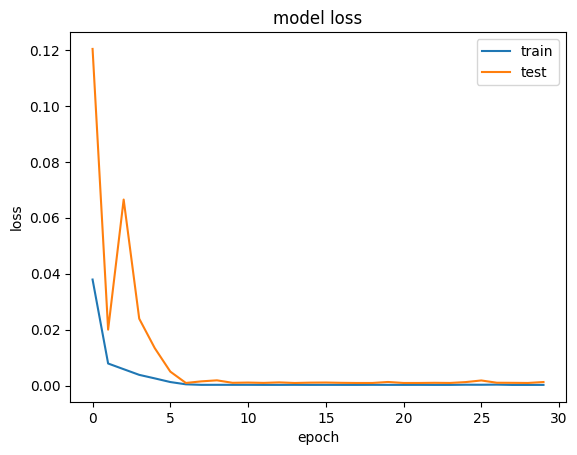

In [31]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [32]:
predictions_train = model.predict(X_train)

inverse_predictions_train = inverse_transform(scaler, predictions_train)
y_train_original = scaler.inverse_transform(np.concatenate((X_train[:, -1, :], y_train.reshape(-1, 1)), axis=1))[:, -1]

compare_model_train = pd.DataFrame({'Predicted': inverse_predictions_train, 'Actual': y_train_original})
compare_model_train.head()

,Predicted,Actual
0,23454.791207,23475.466797
1,23528.986892,22362.679688
2,22896.715747,22353.349609
3,22465.333065,22435.513672
4,22551.350874,22429.757813


In [33]:
predictions_test = model.predict(X_test)

inverse_predictions_test = inverse_transform(scaler, predictions_test)
y_test_original = scaler.inverse_transform(np.concatenate((X_test[:, -1, :], y_test.reshape(-1, 1)), axis=1))[:, -1]

compare_model_test = pd.DataFrame({'Predicted': inverse_predictions_test, 'Actual': y_test_original})
compare_model_test.head()

,Predicted,Actual
0,41237.593320,42270.527344
1,41973.464436,43652.250000
2,42594.974723,43869.152344
3,43313.127787,43997.902344
4,43463.695291,43739.542969


# METRIKS EVALUASI

In [34]:
mse_model_train = mean_squared_error(y_train_original, inverse_predictions_train)
mse_model_test = mean_squared_error(y_test_original, inverse_predictions_test)
rmse_model_train = np.sqrt(mse_model_train)
rmse_model_test = np.sqrt(mse_model_test)
print("Root Mean Squared Error (RMSE) Train Set:", rmse_model_train)
print("Root Mean Squared Error (RMSE) Test Set:", rmse_model_test)
print("======================================================")

r2_xgb_train = r2_score(y_train, predictions_train)
r2_xgb_test = r2_score(y_test, predictions_test)
print("\nR-squared Train Set:", r2_xgb_train)
print("R-squared Test Set:", r2_xgb_test)
print("======================================================")

Root Mean Squared Error (RMSE) Train Set: 877.523559342208
Root Mean Squared Error (RMSE) Test Set: 1541.233161732805

R-squared Train Set: 0.9650294956663561
R-squared Test Set: 0.8991687281233806


# VISUALISASI

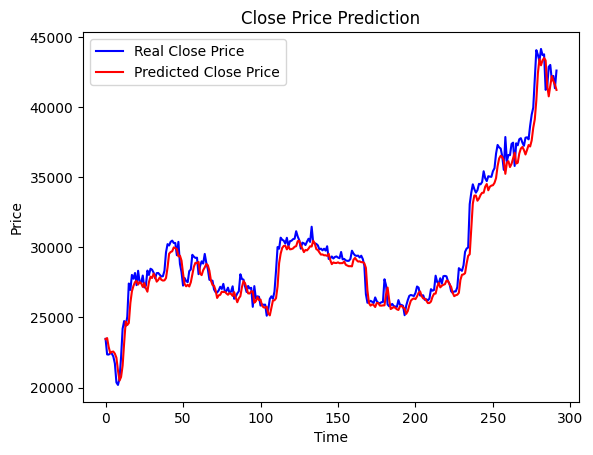

In [35]:
# lineplot train
lineplot(y_train_original, inverse_predictions_train)


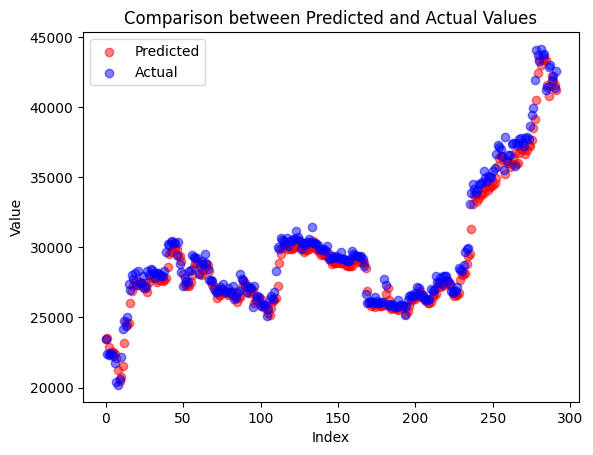

In [36]:
# scatterplot train
scatterplot(y_train_original, inverse_predictions_train)


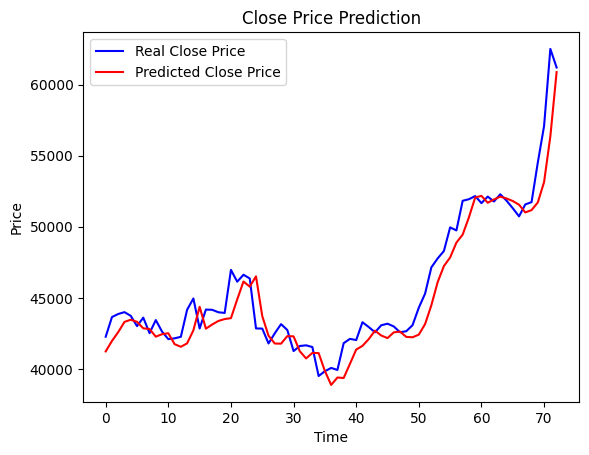

In [37]:
# lineplot test
lineplot(y_test_original, inverse_predictions_test)

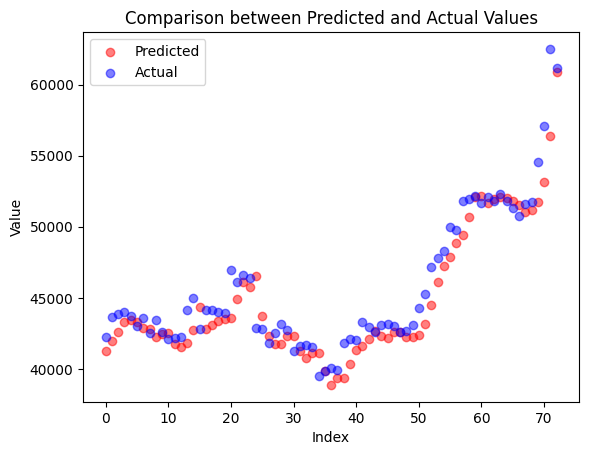

In [38]:
# scatterplot test
scatterplot(y_test_original, inverse_predictions_test)

# SHAP

In [39]:
X_train.shape

(292, 1, 4)

In [40]:
X_test.shape

(73, 1, 4)

In [41]:
features = ["Open", "High", "Low", "Adj Close"]

explainer = shap.DeepExplainer(model, X_train)
shap_values = explainer.shap_values(X_test)

shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0], features)